In [142]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import BlockRNNModel
from sklearn.ensemble import RandomForestRegressor
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display, clear_output

In [2]:
mapa_meses = {'jan':1,'fev':2,'mar':3,'abr':4,'mai':5,'jun':6,'jul':7,'ago':8,'set':9,'out':10,'nov':11,'dez':12}
new_names = {'Garantia física no centro de gravidade MW médios (GFIS_2p,j)':'Garantia Física',
    'Geração no Centro de Gravidade - MW médios (Gp,j)':'Geração'}
df = pd.read_excel('MRE - Geração x Garantia Física - Mês.xlsx').set_index('Unnamed: 0').T.rename(new_names,axis = 1)
df.columns.name = None
df = df.reset_index()
df['index'] = pd.to_datetime(df['index'].apply(lambda x: str(mapa_meses[x[:3]]) + x[3] + '20' + x[4:]),format = '%m/%Y')
df = df.set_index('index')
df

,Garantia Física,Geração
index,,
2013-11-01,44249.296857,46918.159999
2013-12-01,44653.473766,48290.107224
2014-01-01,52528.089619,51849.519718
2014-02-01,50322.506667,50765.843914
2014-03-01,49371.209376,46762.666179
...,...,...
2022-08-01,54603.012198,41652.407403
2022-09-01,59176.162068,41907.597156
2022-10-01,61023.917904,42495.882011


<AxesSubplot:xlabel='index'>

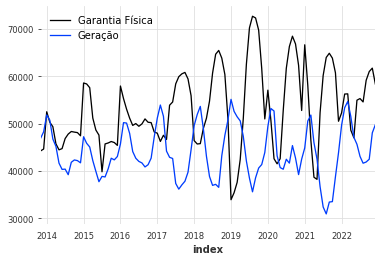

In [3]:
df.plot()

In [28]:
class LSTM:
    def __init__(self,main_serie,extra_series):
        self.last = main_serie.values[-1]
        self.data = TimeSeries.from_dataframe(main_serie)
        self.extra_data = TimeSeries.from_dataframe(extra_series)
        self.scaler_y = Scaler()
        self.transformed_data = self.scaler_y.fit_transform(self.data)
        self.scaler_x = Scaler()
        self.transformed_extra_data = self.scaler_x.fit_transform(self.extra_data)
    def fit(self,input_size,output_size):
        self.model_cov = BlockRNNModel(
            model = "LSTM",
            input_chunk_length = input_size,
            output_chunk_length = output_size,
            n_epochs = 300,
        )
        self.model_cov.fit(
            series = self.transformed_data,
            past_covariates = self.transformed_extra_data,
            verbose = False,
        )
        return self
    def predict(self,n):
        prediction = self.model_cov.predict(n = n,series = self.transformed_data, past_covariates = self.transformed_extra_data)
        converted_prediction = self.scaler_y.inverse_transform(prediction).values().ravel()
        difference = converted_prediction[0] - self.last
        prediction_final = converted_prediction - difference
        return prediction_final

In [154]:
class Forest:
    def __init__(self,df):
        df = df.copy()
        self.last_date = df.index[-1]
        df['mes'] = df.index.month
        df['quarter'] = df.index.quarter
        ger,gf = df['Geração'].values,df['Garantia Física'].values
        x = df[['mes','quarter']].values
        self.model_ger = RandomForestRegressor(max_depth=10).fit(x,ger)
        self.model_gf = RandomForestRegressor(max_depth=10).fit(x,gf)
    def predict(self,n):
        date_range = pd.date_range(start = self.last_date + relativedelta(months = 1),periods = n,freq = 'MS')
        df = pd.DataFrame(index = date_range)
        df['mes'] = df.index.month
        df['quarter'] = df.index.quarter
        x_fut = df.values
        df['prediction'] = self.model_ger.predict(x_fut) / self.model_gf.predict(x_fut)
        return df[['prediction']]

<AxesSubplot:xlabel='index'>

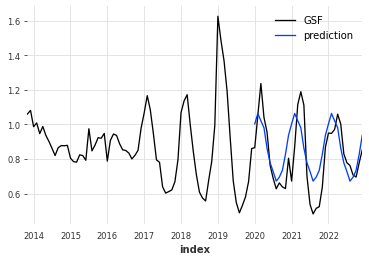

In [155]:
steps = 36
train,test = df.iloc[:-steps],df.iloc[-steps:]
model = Forest(train)
prediction = model.predict(steps)
pred_df = df.copy()
pred_df['GSF'] = pred_df['Geração'] / pred_df['Garantia Física']
pred_df['prediction'] = prediction['prediction']
pred_df[['GSF','prediction']].plot()

<AxesSubplot:>

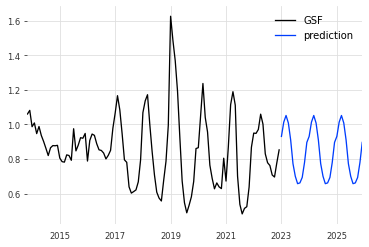

In [156]:
steps = 36
model = Forest(df)
prediction = model.predict(steps)
pred_df = df.copy()
pred_df['GSF'] = pred_df['Geração'] / pred_df['Garantia Física']
pred_df = pd.concat([pred_df,prediction])
pred_df[['GSF','prediction']].plot()

In [115]:
def create_grid(args,options):
    mult = [list(options)] * args
    return np.array(np.meshgrid(*mult)).T.reshape(-1,args)

In [135]:
steps = 36
train,test = df.iloc[:-steps],df.iloc[-steps:].copy()
test['GSF'] = test['Geração'] / test['Garantia Física']
test_values = test['GSF'].values
types = ('add','mul')
values = np.arange(0,1,0.1)
grid_1 = create_grid(4,types)
grid_2 = create_grid(4,values)
n_tests = len(grid_1) * len(grid_2)
print(n_tests)

160000


In [144]:
lower_mse = 10000000
best_args = []
i = 0
for args_1 in grid_1:
    for args_2 in grid_2:
        i += 1
        model_ger = ExponentialSmoothing(train['Geração'].values,seasonal_periods = 12,trend = args_1[0],seasonal = args_1[1]).fit(smoothing_level=args_2[0],smoothing_trend=args_2[1])
        model_gf = ExponentialSmoothing(train['Garantia Física'].values,seasonal_periods = 12,trend = args_1[2],seasonal = args_1[3]).fit(smoothing_level=args_2[2],smoothing_trend=args_2[3])
        pred = model_ger.forecast(steps).ravel() / model_gf.forecast(steps).ravel()
        mse = mean_squared_error(test_values,pred)
        if mse < lower_mse:
            lower_mse = mse
            best_args = [args_1,args_2]
        if i % (n_tests / 1000) == 0:
            clear_output(wait=True)
            display('Progress: ' + str(i / (n_tests / 100)) + ' %,' + f' Score: {lower_mse}')

'Progress: 100.0 %, Score: 0.014866376303958586'

<AxesSubplot:xlabel='index'>

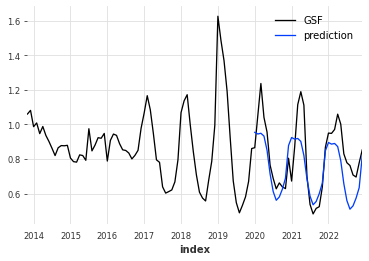

In [146]:
best_args = [['mul', 'add', 'mul', 'add'],[0.1, 0.8, 0.6, 0.2]]
args_1,args_2 = best_args[0],best_args[1]
model_ger = ExponentialSmoothing(train['Geração'].values,seasonal_periods = 12,trend = args_1[0],seasonal = args_1[1]).fit(smoothing_level=args_2[0],smoothing_trend=args_2[1])
model_gf = ExponentialSmoothing(train['Garantia Física'].values,seasonal_periods = 12,trend = args_1[2],seasonal = args_1[3]).fit(smoothing_level=args_2[2],smoothing_trend=args_2[3])
pred = model_ger.forecast(steps).ravel() / model_gf.forecast(steps).ravel()
pred_df = df.copy()
pred_df['GSF'] = pred_df['Geração'] / pred_df['Garantia Física']
pred_df['prediction'] = ([None] * len(train)) + list(pred)
pred_df[['GSF','prediction']].plot()

<AxesSubplot:>

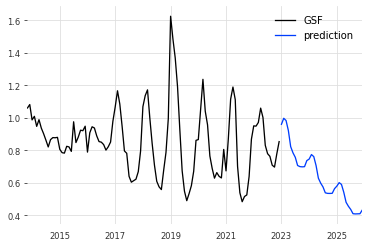

In [149]:
best_args = [['mul', 'add', 'mul', 'add'],[0.1, 0.8, 0.6, 0.2]]
args_1,args_2 = best_args[0],best_args[1]
model_ger = ExponentialSmoothing(df['Geração'].values,seasonal_periods = 12,trend = args_1[0],seasonal = args_1[1]).fit(smoothing_level=args_2[0],smoothing_trend=args_2[1])
model_gf = ExponentialSmoothing(df['Garantia Física'].values,seasonal_periods = 12,trend = args_1[2],seasonal = args_1[3]).fit(smoothing_level=args_2[2],smoothing_trend=args_2[3])
pred = model_ger.forecast(steps).ravel() / model_gf.forecast(steps).ravel()
pred_df = df.copy()
pred_df['GSF'] = pred_df['Geração'] / pred_df['Garantia Física']
last_date = df.index[-1]
date_range = pd.date_range(start = last_date + relativedelta(months = 1),periods = steps,freq = 'MS')
pred = pd.DataFrame({'prediction':pred},index = date_range)
pred_df = pd.concat([pred_df,pred])
pred_df[['GSF','prediction']].plot()